In [1]:
# Malta Traffic Accident Analysis - Exploratory Data Analysis
# ICS5110 Applied Machine Learning Assignment
# Student: Naomi Thornley
# Date: January 2026

"""
This notebook explores the cleaned Malta traffic accident dataset.

Research Questions:
RQ1: How accurately can machine learning predict whether an accident will 
     result in minor or severe injuries?
RQ2: Which features (time, location, vehicle type, weather) matter most 
     for predicting accident severity?
     Note: Driver age not available - focusing on available features
RQ3: Does motorcycle involvement increase the severity of accidents in Malta?

I'll analyze patterns, distributions, and relationships to understand:
- Severity distributions (for RQ1 binary classification)
- Feature importance patterns (for RQ2)
- Motorcycle impact on severity (for RQ3)
- Temporal patterns (day of week, season, time)
- Weather impacts (rain, wind, temperature)
- Geographic patterns (Malta main island, urban vs rural)
- Vehicle involvement patterns

This analysis will prepare us for ML modeling and help answer all three 
research questions.
"""

# IMPORT LIBRARIES

print("Loading libraries for EDA...")

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical tests (might need these later)
from scipy import stats

# Make plots look nice
plt.style.use('default')
sns.set_palette("husl")

# Settings for better display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Make plots show up in notebook
%matplotlib inline

# Set default figure size
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ All libraries loaded!")

Loading libraries for EDA...
✅ All libraries loaded!


In [2]:
# LOAD THE CLEAN DATASET

print("="*70)
print("LOADING CLEANED DATA")
print("="*70)

# Load the ML-ready dataset I created in Notebook 1
# Using ../ because we're in the notebooks/ folder
df = pd.read_csv('../data/processed/accidents_ml_ready.csv')

print(f"\n✅ Data loaded successfully!")
print(f"   Records: {len(df)}")
print(f"   Features: {len(df.columns)}")

# Quick peek at the data
print(f"\n👀 First few rows:")
print(df.head(3))

print(f"\n📋 Column names:")
print(df.columns.tolist())

LOADING CLEANED DATA

✅ Data loaded successfully!
   Records: 318
   Features: 33

👀 First few rows:
                                            title        date  \
0  Collision between motorcycle and car in Għaxaq  2025-07-30   
1                       Traffic accident in Marsa  2025-04-16   
2                       Van-car collision in Lija  2025-07-23   

                                             content  source   time  severity  \
0  Yesterday, at around 1800hrs, the Police were ...  police  18:00  grievous   
1  Yesterday, at around ten minutes to nine in th...  police  08:50  grievous   
2  Today, at around 1030hrs, the Police were info...  police  10:30   serious   

          vehicles location region  year  month day_of_week  is_weekend  \
0  motorcycle, car   Għaxaq  Malta  2025      7   Wednesday           0   
1  motorcycle, van    Marsa  Malta  2025      4   Wednesday           0   
2         car, van    Mosta  Malta  2025      7   Wednesday           0   

   has_time 

In [3]:
# BASIC DATASET OVERVIEW

print("="*70)
print("DATASET OVERVIEW")
print("="*70)

print(f"\n📊 DATASET SIZE:")
print(f"   Total accidents: {len(df)}")
print(f"   Features: {len(df.columns)}")
print(f"   Memory usage: {df.memory_usage(deep=True).sum() / 1024:.1f} KB")

print(f"\n📝 DATA TYPES:")
print(df.dtypes.value_counts())

print(f"\n❓ MISSING VALUES:")
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(1)
missing_df = pd.DataFrame({
    'Missing': missing,
    'Percentage': missing_pct
})
missing_df = missing_df[missing_df['Missing'] > 0].sort_values('Missing', ascending=False)

if len(missing_df) > 0:
    print("\nFeatures with missing data:")
    print(missing_df)
else:
    print("   ✅ No missing values!")

print(f"\n📋 FEATURE CATEGORIES:")
print(f"   Target variable: severity, severity_binary, severity_3class")
print(f"   Temporal features: {[col for col in df.columns if col in ['time', 'hour', 'day_of_week', 'month', 'season', 'is_weekend', 'is_holiday', 'time_of_day', 'hour_category']]}")
print(f"   Location features: {[col for col in df.columns if col in ['location', 'region', 'area_type', 'has_location']]}")
print(f"   Weather features: {[col for col in df.columns if col in ['temperature', 'precipitation', 'wind_speed', 'weather_condition', 'is_rainy', 'is_foggy', 'is_windy']]}")
print(f"   Vehicle features: {[col for col in df.columns if col in ['vehicles', 'vehicle_category', 'has_motorcycle']]}")

DATASET OVERVIEW

📊 DATASET SIZE:
   Total accidents: 318
   Features: 33
   Memory usage: 1016.7 KB

📝 DATA TYPES:
object     18
int64      11
float64     4
Name: count, dtype: int64

❓ MISSING VALUES:

Features with missing data:
      Missing  Percentage
time      255        80.2
hour      255        80.2

📋 FEATURE CATEGORIES:
   Target variable: severity, severity_binary, severity_3class
   Temporal features: ['time', 'month', 'day_of_week', 'is_weekend', 'hour', 'time_of_day', 'season', 'hour_category', 'is_holiday']
   Location features: ['location', 'region', 'has_location', 'area_type']
   Weather features: ['temperature', 'precipitation', 'wind_speed', 'weather_condition', 'is_rainy', 'is_foggy', 'is_windy']
   Vehicle features: ['vehicles', 'has_motorcycle', 'vehicle_category']


In [4]:
# SUMMARY STATISTICS - NUMERICAL FEATURES

print("="*70)
print("SUMMARY STATISTICS - NUMERICAL FEATURES")
print("="*70)

# Select only numerical columns
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# Remove year and weather_code (not really useful as numbers)
numerical_cols = [col for col in numerical_cols if col not in ['year', 'weather_code', 'is_weekend', 'is_holiday', 'is_rainy', 'is_foggy', 'is_windy', 'has_time', 'has_location', 'has_motorcycle']]

print(f"\n📊 Numerical features: {numerical_cols}\n")

# Get summary stats
summary = df[numerical_cols].describe()
print(summary.round(2))

# Additional stats
print(f"\n📈 Additional statistics:")
for col in numerical_cols:
    if df[col].notna().sum() > 0:
        print(f"\n{col}:")
        print(f"   Range: {df[col].min():.1f} to {df[col].max():.1f}")
        print(f"   Median: {df[col].median():.1f}")
        print(f"   Mode: {df[col].mode().values[0] if len(df[col].mode()) > 0 else 'N/A'}")
        print(f"   Std Dev: {df[col].std():.1f}")

SUMMARY STATISTICS - NUMERICAL FEATURES

📊 Numerical features: ['month', 'hour', 'temperature', 'precipitation', 'wind_speed']

        month   hour  temperature  precipitation  wind_speed
count  318.00  63.00       318.00         318.00      318.00
mean     6.49  12.86        21.24           0.84       19.91
std      3.25   5.37         5.47           4.01        8.53
min      1.00   1.00        12.00           0.00        6.10
25%      4.00   9.00        15.72           0.00       13.20
50%      7.00  12.00        21.70           0.00       18.70
75%      9.00  17.00        26.30           0.40       25.00
max     12.00  23.00        29.70          62.30       48.70

📈 Additional statistics:

month:
   Range: 1.0 to 12.0
   Median: 7.0
   Mode: 8
   Std Dev: 3.2

hour:
   Range: 1.0 to 23.0
   Median: 12.0
   Mode: 8.0
   Std Dev: 5.4

temperature:
   Range: 12.0 to 29.7
   Median: 21.7
   Mode: 27.5
   Std Dev: 5.5

precipitation:
   Range: 0.0 to 62.3
   Median: 0.0
   Mode: 0.0
  

In [5]:
# SUMMARY STATISTICS - CATEGORICAL FEATURES

print("="*70)
print("SUMMARY STATISTICS - CATEGORICAL FEATURES")
print("="*70)

# Key categorical features to analyze
categorical_features = {
    'severity': 'Accident Severity',
    'severity_binary': 'Severity (Binary)',
    'day_of_week': 'Day of Week',
    'region': 'Region',
    'weather_condition': 'Weather Condition',
    'vehicle_category': 'Vehicle Category',
    'time_of_day': 'Time of Day',
    'season': 'Season',
    'area_type': 'Area Type'
}

for col, description in categorical_features.items():
    if col in df.columns:
        print(f"\n📊 {description} ({col}):")
        counts = df[col].value_counts()
        for category, count in counts.items():
            pct = count / len(df) * 100
            print(f"   {category}: {count} ({pct:.1f}%)")

SUMMARY STATISTICS - CATEGORICAL FEATURES

📊 Accident Severity (severity):
   grievous: 156 (49.1%)
   fatal: 95 (29.9%)
   serious: 60 (18.9%)
   slight: 7 (2.2%)

📊 Severity (Binary) (severity_binary):
   high: 251 (78.9%)
   low: 67 (21.1%)

📊 Day of Week (day_of_week):
   Sunday: 51 (16.0%)
   Thursday: 50 (15.7%)
   Tuesday: 50 (15.7%)
   Wednesday: 48 (15.1%)
   Monday: 46 (14.5%)
   Saturday: 39 (12.3%)
   Friday: 34 (10.7%)

📊 Region (region):
   Malta: 264 (83.0%)
   unknown: 38 (11.9%)
   Gozo: 16 (5.0%)

📊 Weather Condition (weather_condition):
   partly_cloudy: 134 (42.1%)
   rain: 107 (33.6%)
   clear: 77 (24.2%)

📊 Vehicle Category (vehicle_category):
   other: 133 (41.8%)
   motorcycle_involved: 115 (36.2%)
   car_only: 70 (22.0%)

📊 Time of Day (time_of_day):
   unknown: 255 (80.2%)
   morning: 27 (8.5%)
   afternoon: 18 (5.7%)
   evening: 10 (3.1%)
   night: 8 (2.5%)

📊 Season (season):
   summer: 153 (48.1%)
   winter: 89 (28.0%)
   spring_autumn: 76 (23.9%)

📊 Area T

VISUALIZING TARGET VARIABLE - ACCIDENT SEVERITY


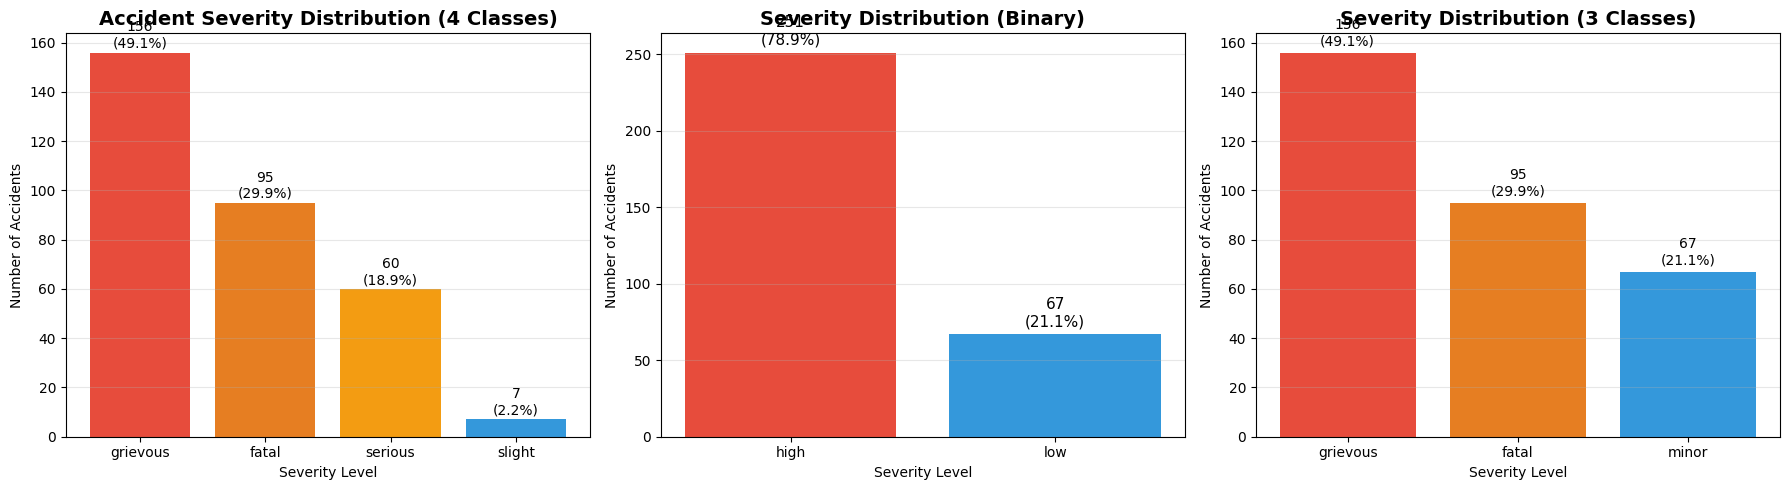


✅ Target variable visualizations created!

💡 Insights:
   - Grievous injuries are most common (49.1%)
   - Fatal accidents are 29.9% - significant!
   - Only 7 'slight' cases - too few for 4-class modeling
   - Binary classification is well-balanced (79% vs 21%)
   - Recommendation: Use binary or 3-class target for ML


In [6]:
# VISUALIZATIONS - TARGET VARIABLE (SEVERITY)

print("="*70)
print("VISUALIZING TARGET VARIABLE - ACCIDENT SEVERITY")
print("="*70)

# Create figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Original severity (4 classes)
severity_counts = df['severity'].value_counts()
axes[0].bar(severity_counts.index, severity_counts.values, color=['#e74c3c', '#e67e22', '#f39c12', '#3498db'])
axes[0].set_title('Accident Severity Distribution (4 Classes)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Severity Level')
axes[0].set_ylabel('Number of Accidents')
axes[0].grid(axis='y', alpha=0.3)

# Add counts on bars
for i, (severity, count) in enumerate(severity_counts.items()):
    pct = count / len(df) * 100
    axes[0].text(i, count + 2, f'{count}\n({pct:.1f}%)', ha='center', fontsize=10)

# Plot 2: Binary severity
binary_counts = df['severity_binary'].value_counts()
colors_binary = ['#e74c3c', '#3498db']
axes[1].bar(binary_counts.index, binary_counts.values, color=colors_binary)
axes[1].set_title('Severity Distribution (Binary)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Severity Level')
axes[1].set_ylabel('Number of Accidents')
axes[1].grid(axis='y', alpha=0.3)

# Add counts on bars
for i, (severity, count) in enumerate(binary_counts.items()):
    pct = count / len(df) * 100
    axes[1].text(i, count + 5, f'{count}\n({pct:.1f}%)', ha='center', fontsize=11)

# Plot 3: 3-class severity
class3_counts = df['severity_3class'].value_counts()
axes[2].bar(class3_counts.index, class3_counts.values, color=['#e74c3c', '#e67e22', '#3498db'])
axes[2].set_title('Severity Distribution (3 Classes)', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Severity Level')
axes[2].set_ylabel('Number of Accidents')
axes[2].grid(axis='y', alpha=0.3)

# Add counts on bars
for i, (severity, count) in enumerate(class3_counts.items()):
    pct = count / len(df) * 100
    axes[2].text(i, count + 3, f'{count}\n({pct:.1f}%)', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('../outputs/figures/severity_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Target variable visualizations created!")
print(f"\n💡 Insights:")
print(f"   - Grievous injuries are most common (49.1%)")
print(f"   - Fatal accidents are 29.9% - significant!")
print(f"   - Only 7 'slight' cases - too few for 4-class modeling")
print(f"   - Binary classification is well-balanced (79% vs 21%)")
print(f"   - Recommendation: Use binary or 3-class target for ML")

TEMPORAL ANALYSIS - DAY OF WEEK


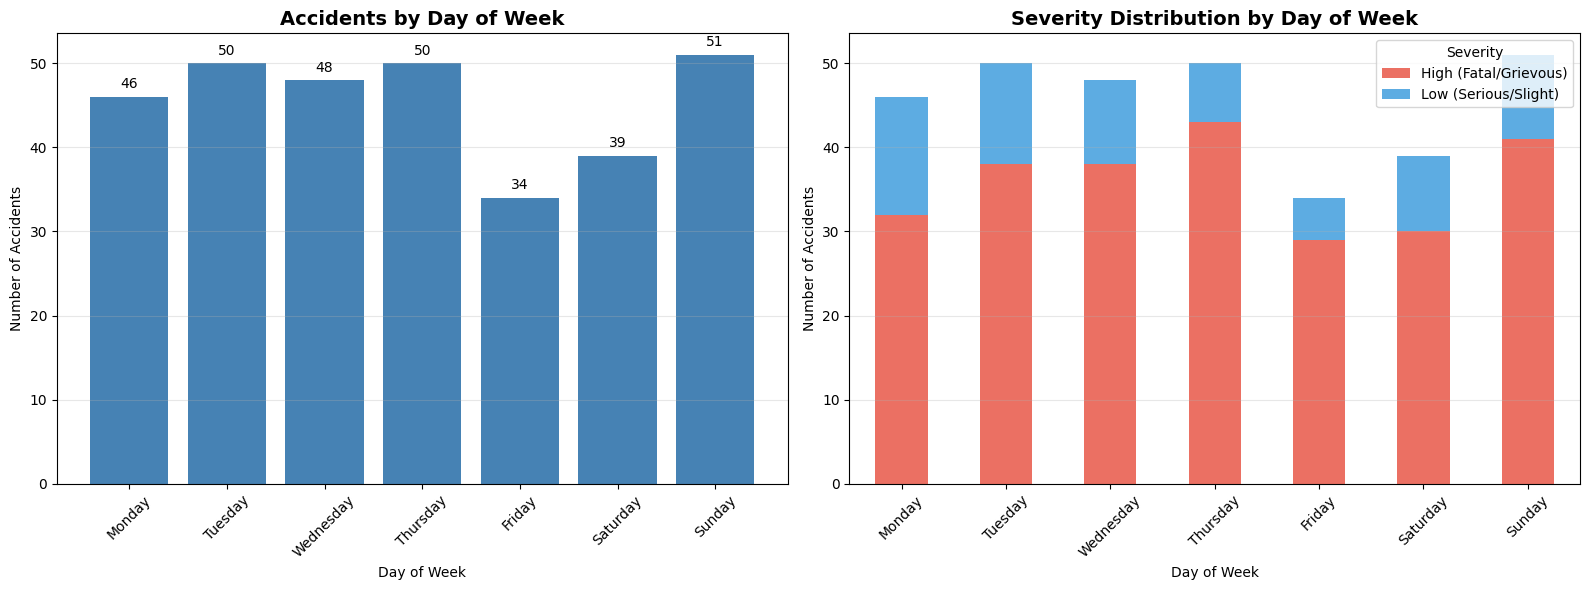


📊 Day of week statistics:
day_of_week
Monday       46
Tuesday      50
Wednesday    48
Thursday     50
Friday       34
Saturday     39
Sunday       51
Name: count, dtype: int64

📅 Weekday vs Weekend:
   Weekday: 228 (71.7%)
   Weekend: 90 (28.3%)

💡 Insights:
   - Most accidents on: Sunday (51 accidents)
   - Fewest accidents on: Friday (34 accidents)
   - 71.7% of accidents happen on weekdays


In [7]:
# TEMPORAL PATTERNS - DAY OF WEEK

print("="*70)
print("TEMPORAL ANALYSIS - DAY OF WEEK")
print("="*70)

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Order days properly
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts = df['day_of_week'].value_counts().reindex(day_order)

# Plot 1: Total accidents by day
axes[0].bar(day_order, day_counts.values, color='steelblue')
axes[0].set_title('Accidents by Day of Week', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Day of Week')
axes[0].set_ylabel('Number of Accidents')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Add counts on bars
for i, count in enumerate(day_counts.values):
    axes[0].text(i, count + 1, str(count), ha='center', fontsize=10)

# Plot 2: Severity by day of week (stacked bar)
severity_by_day = pd.crosstab(df['day_of_week'], df['severity_binary'])
severity_by_day = severity_by_day.reindex(day_order)

severity_by_day.plot(kind='bar', stacked=True, ax=axes[1], 
                      color=['#e74c3c', '#3498db'], alpha=0.8)
axes[1].set_title('Severity Distribution by Day of Week', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Day of Week')
axes[1].set_ylabel('Number of Accidents')
axes[1].legend(title='Severity', labels=['High (Fatal/Grievous)', 'Low (Serious/Slight)'])
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/day_of_week_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Statistical insight
print(f"\n📊 Day of week statistics:")
print(day_counts)

# Weekday vs Weekend
weekday_accidents = df[df['is_weekend'] == 0]
weekend_accidents = df[df['is_weekend'] == 1]

print(f"\n📅 Weekday vs Weekend:")
print(f"   Weekday: {len(weekday_accidents)} ({len(weekday_accidents)/len(df)*100:.1f}%)")
print(f"   Weekend: {len(weekend_accidents)} ({len(weekend_accidents)/len(df)*100:.1f}%)")

print(f"\n💡 Insights:")
print(f"   - Most accidents on: {day_counts.idxmax()} ({day_counts.max()} accidents)")
print(f"   - Fewest accidents on: {day_counts.idxmin()} ({day_counts.min()} accidents)")
print(f"   - {len(weekday_accidents)/len(df)*100:.1f}% of accidents happen on weekdays")

TEMPORAL ANALYSIS - SEASON & MONTH


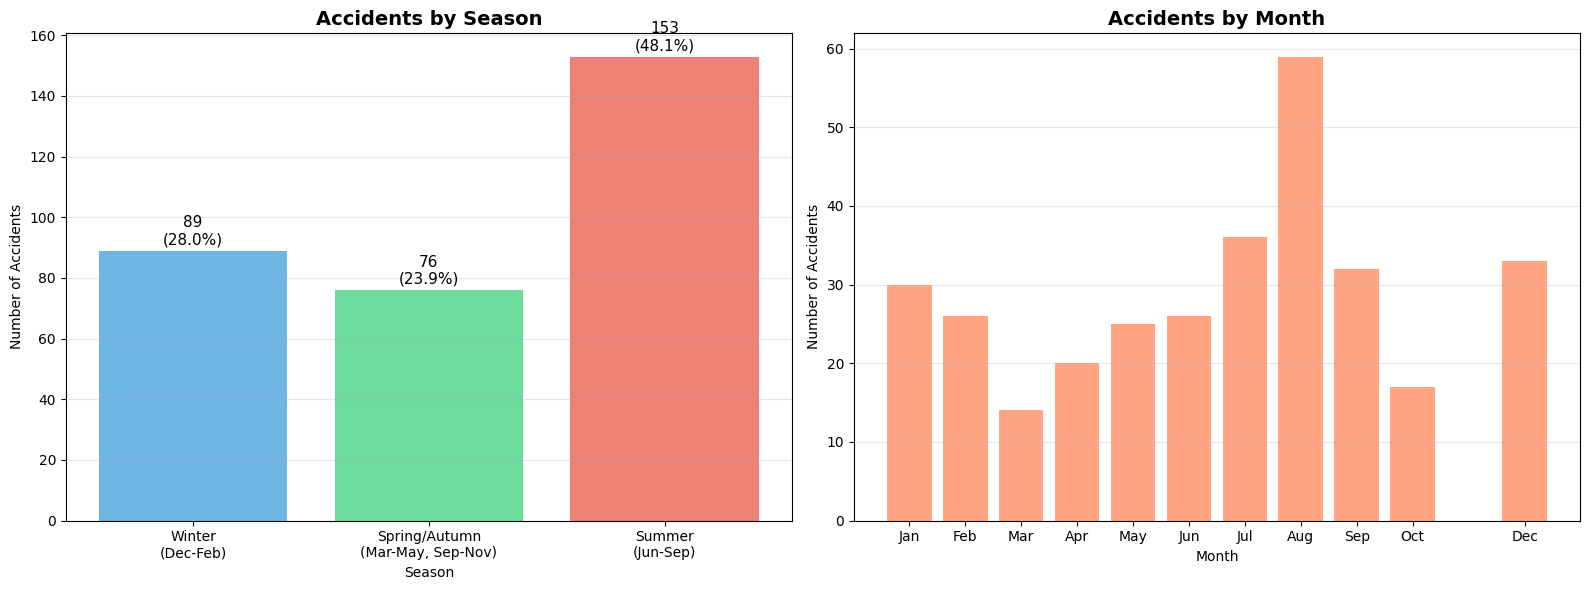


🌞 Seasonal distribution:
   winter: 89 (28.0%)
   spring_autumn: 76 (23.9%)
   summer: 153 (48.1%)

📅 Months with data: ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Dec']
📅 Month with most accidents: Aug (59 accidents)
💡 Insight: Summer has most accidents (48%) - likely tourist season effect!


In [8]:
# TEMPORAL PATTERNS - SEASON AND MONTH

print("="*70)
print("TEMPORAL ANALYSIS - SEASON & MONTH")
print("="*70)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Accidents by season
season_order = ['winter', 'spring_autumn', 'summer']
season_counts = df['season'].value_counts().reindex(season_order)

colors_season = ['#3498db', '#2ecc71', '#e74c3c']
axes[0].bar(range(len(season_order)), season_counts.values, color=colors_season, alpha=0.7)
axes[0].set_title('Accidents by Season', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Season')
axes[0].set_ylabel('Number of Accidents')
axes[0].set_xticks(range(len(season_order)))
axes[0].set_xticklabels(['Winter\n(Dec-Feb)', 'Spring/Autumn\n(Mar-May, Sep-Nov)', 'Summer\n(Jun-Sep)'])
axes[0].grid(axis='y', alpha=0.3)

# Add counts
for i, (season, count) in enumerate(zip(season_order, season_counts.values)):
    pct = count / len(df) * 100
    axes[0].text(i, count + 2, f'{count}\n({pct:.1f}%)', ha='center', fontsize=11)

# Plot 2: Accidents by month (FIXED - only plot months that have data)
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_counts = df['month'].value_counts().sort_index()

# Only plot the months that actually have data
months_with_data = month_counts.index.tolist()
month_values = month_counts.values
month_labels = [month_names[m-1] for m in months_with_data]

axes[1].bar(months_with_data, month_values, color='coral', alpha=0.7)
axes[1].set_title('Accidents by Month', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Number of Accidents')
axes[1].set_xticks(months_with_data)
axes[1].set_xticklabels(month_labels)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/seasonal_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n🌞 Seasonal distribution:")
for season in season_order:
    count = season_counts[season]
    pct = count / len(df) * 100
    print(f"   {season}: {count} ({pct:.1f}%)")

print(f"\n📅 Months with data: {month_labels}")
print(f"📅 Month with most accidents: {month_names[month_counts.idxmax()-1]} ({month_counts.max()} accidents)")
print(f"💡 Insight: Summer has most accidents (48%) - likely tourist season effect!")

WEATHER IMPACT ON ACCIDENT SEVERITY


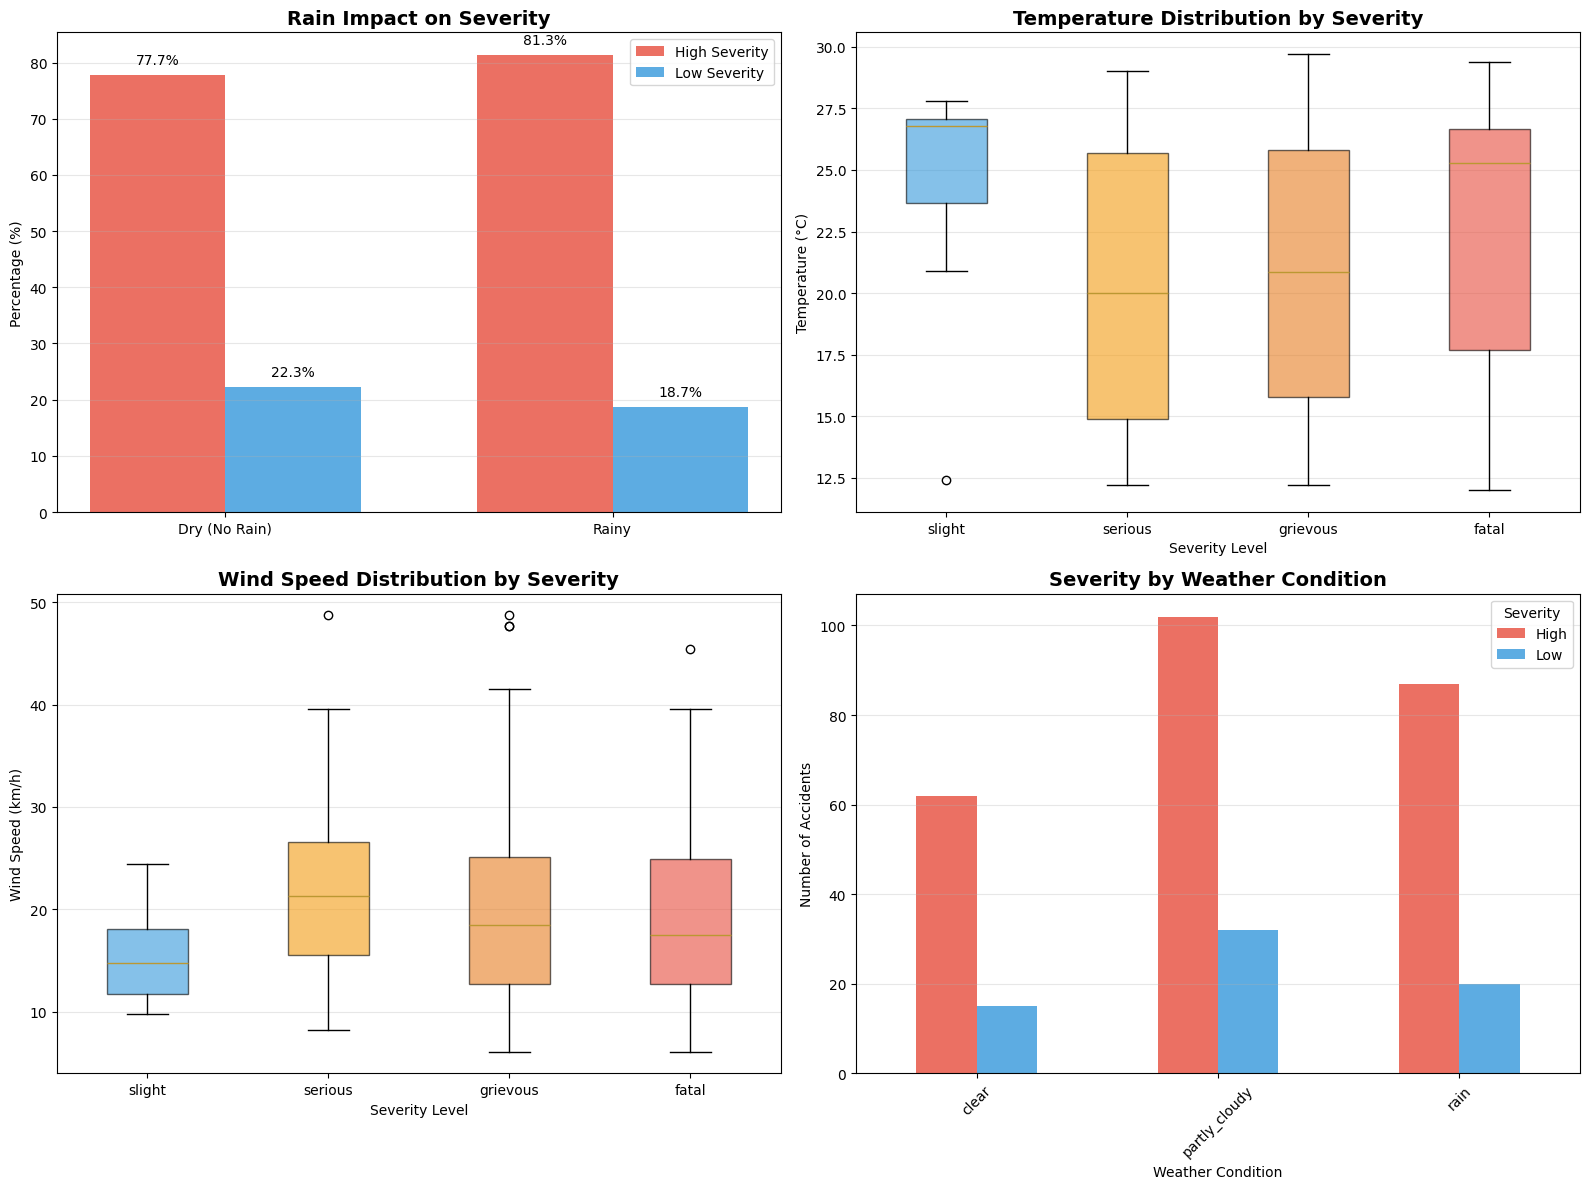


💡 Weather Impact Insights:
   - Rainy conditions: 107 accidents (33.6%)
   - High severity in rain: 81.3%
   - High severity when dry: 77.7%
   - Average temp in fatal accidents: 22.5°C
   - Average wind in fatal accidents: 19.2 km/h


In [9]:
# WEATHER IMPACT ANALYSIS

print("="*70)
print("WEATHER IMPACT ON ACCIDENT SEVERITY")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Rain vs Severity
rain_severity = pd.crosstab(df['is_rainy'], df['severity_binary'], normalize='index') * 100
rain_labels = ['Dry (No Rain)', 'Rainy']

x = np.arange(len(rain_labels))
width = 0.35

high_pct = [rain_severity.loc[0, 'high'], rain_severity.loc[1, 'high']]
low_pct = [rain_severity.loc[0, 'low'], rain_severity.loc[1, 'low']]

axes[0, 0].bar(x - width/2, high_pct, width, label='High Severity', color='#e74c3c', alpha=0.8)
axes[0, 0].bar(x + width/2, low_pct, width, label='Low Severity', color='#3498db', alpha=0.8)
axes[0, 0].set_title('Rain Impact on Severity', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Percentage (%)')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(rain_labels)
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# Add percentage labels
for i, (h, l) in enumerate(zip(high_pct, low_pct)):
    axes[0, 0].text(i - width/2, h + 2, f'{h:.1f}%', ha='center', fontsize=10)
    axes[0, 0].text(i + width/2, l + 2, f'{l:.1f}%', ha='center', fontsize=10)

# Plot 2: Temperature vs Severity (Box plot) - FIXED
severity_order = ['slight', 'serious', 'grievous', 'fatal']
temp_data = [df[df['severity'] == sev]['temperature'].dropna() for sev in severity_order]

bp = axes[0, 1].boxplot(temp_data, tick_labels=severity_order, patch_artist=True)  # Changed labels to tick_labels
for patch, color in zip(bp['boxes'], ['#3498db', '#f39c12', '#e67e22', '#e74c3c']):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

axes[0, 1].set_title('Temperature Distribution by Severity', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Severity Level')
axes[0, 1].set_ylabel('Temperature (°C)')
axes[0, 1].grid(axis='y', alpha=0.3)

# Plot 3: Wind Speed vs Severity (Box plot) - FIXED
wind_data = [df[df['severity'] == sev]['wind_speed'].dropna() for sev in severity_order]

bp2 = axes[1, 0].boxplot(wind_data, tick_labels=severity_order, patch_artist=True)  # Changed labels to tick_labels
for patch, color in zip(bp2['boxes'], ['#3498db', '#f39c12', '#e67e22', '#e74c3c']):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

axes[1, 0].set_title('Wind Speed Distribution by Severity', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Severity Level')
axes[1, 0].set_ylabel('Wind Speed (km/h)')
axes[1, 0].grid(axis='y', alpha=0.3)

# Plot 4: Weather Condition Distribution
weather_severity = pd.crosstab(df['weather_condition'], df['severity_binary'])
weather_severity.plot(kind='bar', stacked=False, ax=axes[1, 1], 
                      color=['#e74c3c', '#3498db'], alpha=0.8)
axes[1, 1].set_title('Severity by Weather Condition', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Weather Condition')
axes[1, 1].set_ylabel('Number of Accidents')
axes[1, 1].legend(title='Severity', labels=['High', 'Low'])
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/weather_impact_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💡 Weather Impact Insights:")
print(f"   - Rainy conditions: {(df['is_rainy'] == 1).sum()} accidents ({(df['is_rainy'] == 1).sum()/len(df)*100:.1f}%)")
print(f"   - High severity in rain: {high_pct[1]:.1f}%")
print(f"   - High severity when dry: {high_pct[0]:.1f}%")
print(f"   - Average temp in fatal accidents: {df[df['severity'] == 'fatal']['temperature'].mean():.1f}°C")
print(f"   - Average wind in fatal accidents: {df[df['severity'] == 'fatal']['wind_speed'].mean():.1f} km/h")

VEHICLE INVOLVEMENT ANALYSIS


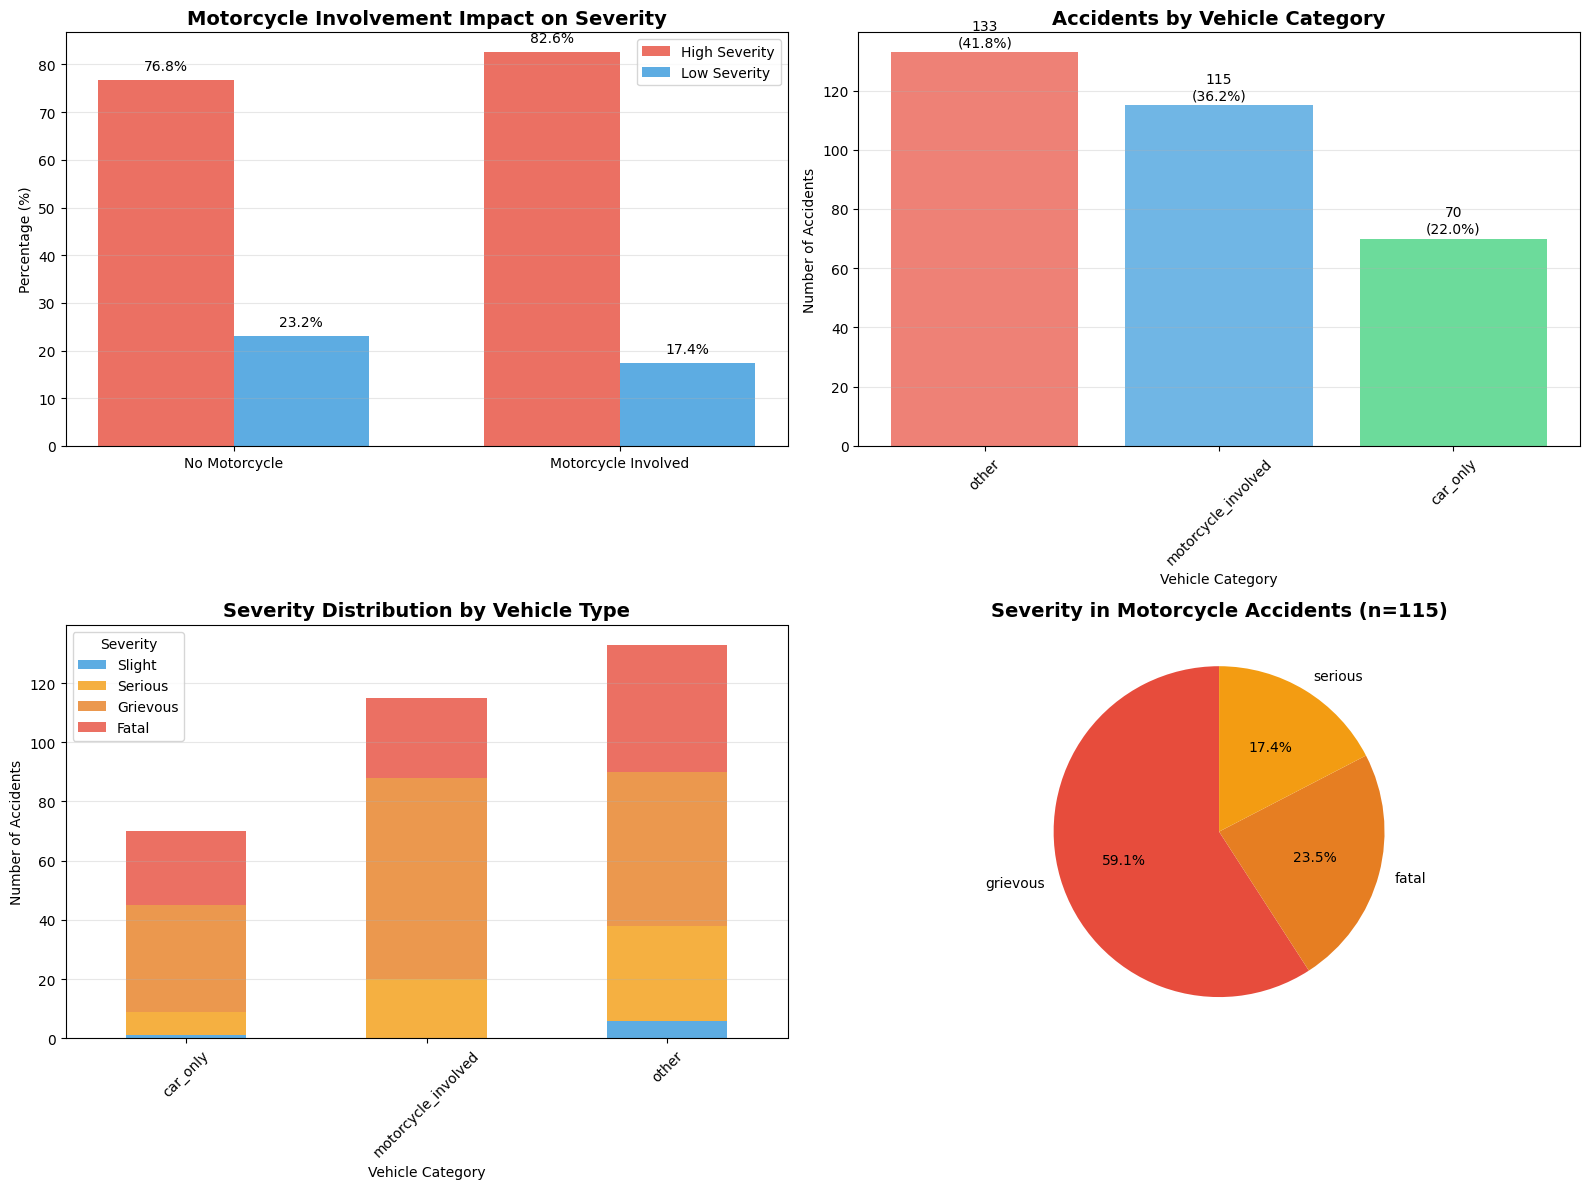


💡 Vehicle Analysis Insights:
   - Total motorcycle accidents: 115 (36.2%)
   - High severity with motorcycle: 82.6%
   - High severity without motorcycle: 76.8%
   - Motorcycle fatal rate: 27/115 (23.5%)


In [10]:
# VEHICLE ANALYSIS

print("="*70)
print("VEHICLE INVOLVEMENT ANALYSIS")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Motorcycle vs No Motorcycle - Severity
moto_severity = pd.crosstab(df['has_motorcycle'], df['severity_binary'], normalize='index') * 100
moto_labels = ['No Motorcycle', 'Motorcycle Involved']

x = np.arange(len(moto_labels))
width = 0.35

high_moto = [moto_severity.loc[0, 'high'], moto_severity.loc[1, 'high']]
low_moto = [moto_severity.loc[0, 'low'], moto_severity.loc[1, 'low']]

axes[0, 0].bar(x - width/2, high_moto, width, label='High Severity', color='#e74c3c', alpha=0.8)
axes[0, 0].bar(x + width/2, low_moto, width, label='Low Severity', color='#3498db', alpha=0.8)
axes[0, 0].set_title('Motorcycle Involvement Impact on Severity', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Percentage (%)')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(moto_labels)
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# Add percentage labels
for i, (h, l) in enumerate(zip(high_moto, low_moto)):
    axes[0, 0].text(i - width/2, h + 2, f'{h:.1f}%', ha='center', fontsize=10)
    axes[0, 0].text(i + width/2, l + 2, f'{l:.1f}%', ha='center', fontsize=10)

# Plot 2: Vehicle Category Distribution
vehicle_counts = df['vehicle_category'].value_counts()
colors_vehicle = ['#e74c3c', '#3498db', '#2ecc71']
axes[0, 1].bar(vehicle_counts.index, vehicle_counts.values, color=colors_vehicle, alpha=0.7)
axes[0, 1].set_title('Accidents by Vehicle Category', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Vehicle Category')
axes[0, 1].set_ylabel('Number of Accidents')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)

# Add counts
for i, (cat, count) in enumerate(vehicle_counts.items()):
    pct = count / len(df) * 100
    axes[0, 1].text(i, count + 2, f'{count}\n({pct:.1f}%)', ha='center', fontsize=10)

# Plot 3: Severity by Vehicle Category
vehicle_severity = pd.crosstab(df['vehicle_category'], df['severity'])
vehicle_severity = vehicle_severity[['slight', 'serious', 'grievous', 'fatal']]
vehicle_severity.plot(kind='bar', stacked=True, ax=axes[1, 0], 
                      color=['#3498db', '#f39c12', '#e67e22', '#e74c3c'], alpha=0.8)
axes[1, 0].set_title('Severity Distribution by Vehicle Type', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Vehicle Category')
axes[1, 0].set_ylabel('Number of Accidents')
axes[1, 0].legend(title='Severity', labels=['Slight', 'Serious', 'Grievous', 'Fatal'])
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(axis='y', alpha=0.3)

# Plot 4: Motorcycle Accidents - Detailed Severity
moto_df = df[df['has_motorcycle'] == 1]
moto_sev_counts = moto_df['severity'].value_counts()
axes[1, 1].pie(moto_sev_counts.values, labels=moto_sev_counts.index, autopct='%1.1f%%',
               colors=['#e74c3c', '#e67e22', '#f39c12', '#3498db'], startangle=90)
axes[1, 1].set_title(f'Severity in Motorcycle Accidents (n={len(moto_df)})', 
                     fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../outputs/figures/vehicle_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💡 Vehicle Analysis Insights:")
print(f"   - Total motorcycle accidents: {(df['has_motorcycle'] == 1).sum()} ({(df['has_motorcycle'] == 1).sum()/len(df)*100:.1f}%)")
print(f"   - High severity with motorcycle: {high_moto[1]:.1f}%")
print(f"   - High severity without motorcycle: {high_moto[0]:.1f}%")
print(f"   - Motorcycle fatal rate: {(moto_df['severity'] == 'fatal').sum()}/{len(moto_df)} ({(moto_df['severity'] == 'fatal').sum()/len(moto_df)*100:.1f}%)")

GEOGRAPHIC ANALYSIS


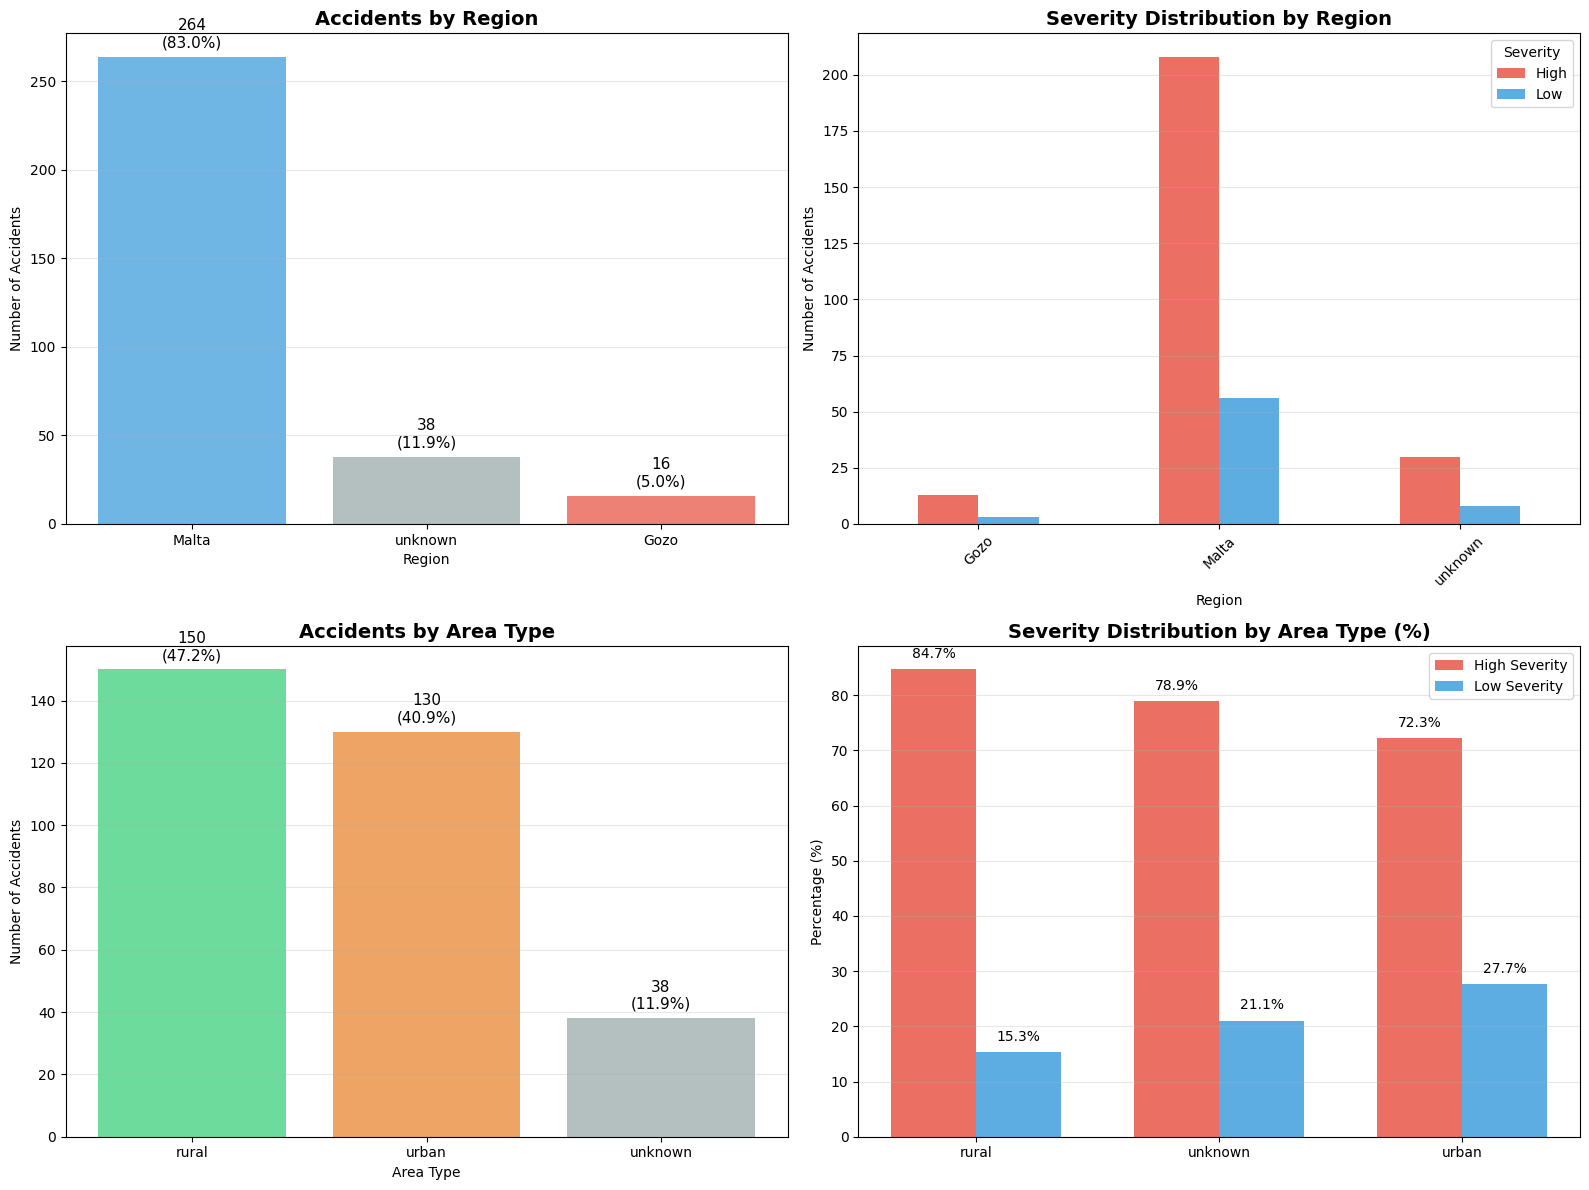


💡 Geographic Insights:
   - Malta: 264 accidents
   - Gozo: 16 accidents
   - Rural: 150 accidents (47.2%)
   - Urban: 130 accidents (40.9%)


In [11]:
# GEOGRAPHIC PATTERNS

print("="*70)
print("GEOGRAPHIC ANALYSIS")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Malta vs Gozo - Total Accidents
region_counts = df['region'].value_counts()
colors_region = ['#3498db', '#95a5a6', '#e74c3c']
axes[0, 0].bar(region_counts.index, region_counts.values, color=colors_region, alpha=0.7)
axes[0, 0].set_title('Accidents by Region', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Region')
axes[0, 0].set_ylabel('Number of Accidents')
axes[0, 0].grid(axis='y', alpha=0.3)

# Add counts
for i, (region, count) in enumerate(region_counts.items()):
    pct = count / len(df) * 100
    axes[0, 0].text(i, count + 5, f'{count}\n({pct:.1f}%)', ha='center', fontsize=11)

# Plot 2: Severity by Region
region_severity = pd.crosstab(df['region'], df['severity_binary'])
region_severity.plot(kind='bar', stacked=False, ax=axes[0, 1], 
                     color=['#e74c3c', '#3498db'], alpha=0.8)
axes[0, 1].set_title('Severity Distribution by Region', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Region')
axes[0, 1].set_ylabel('Number of Accidents')
axes[0, 1].legend(title='Severity', labels=['High', 'Low'])
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)

# Plot 3: Urban vs Rural
area_counts = df['area_type'].value_counts()
colors_area = ['#2ecc71', '#e67e22', '#95a5a6']
axes[1, 0].bar(area_counts.index, area_counts.values, color=colors_area, alpha=0.7)
axes[1, 0].set_title('Accidents by Area Type', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Area Type')
axes[1, 0].set_ylabel('Number of Accidents')
axes[1, 0].grid(axis='y', alpha=0.3)

# Add counts
for i, (area, count) in enumerate(area_counts.items()):
    pct = count / len(df) * 100
    axes[1, 0].text(i, count + 3, f'{count}\n({pct:.1f}%)', ha='center', fontsize=11)

# Plot 4: Severity by Area Type
area_severity = pd.crosstab(df['area_type'], df['severity_binary'], normalize='index') * 100
area_labels = area_severity.index.tolist()

x = np.arange(len(area_labels))
width = 0.35

high_area = area_severity['high'].values
low_area = area_severity['low'].values

axes[1, 1].bar(x - width/2, high_area, width, label='High Severity', color='#e74c3c', alpha=0.8)
axes[1, 1].bar(x + width/2, low_area, width, label='Low Severity', color='#3498db', alpha=0.8)
axes[1, 1].set_title('Severity Distribution by Area Type (%)', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Percentage (%)')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(area_labels)
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

# Add percentage labels
for i, (h, l) in enumerate(zip(high_area, low_area)):
    axes[1, 1].text(i - width/2, h + 2, f'{h:.1f}%', ha='center', fontsize=10)
    axes[1, 1].text(i + width/2, l + 2, f'{l:.1f}%', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('../outputs/figures/geographic_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💡 Geographic Insights:")
print(f"   - Malta: {region_counts.get('Malta', 0)} accidents")
print(f"   - Gozo: {region_counts.get('Gozo', 0)} accidents")
print(f"   - Rural: {area_counts.get('rural', 0)} accidents ({area_counts.get('rural', 0)/len(df)*100:.1f}%)")
print(f"   - Urban: {area_counts.get('urban', 0)} accidents ({area_counts.get('urban', 0)/len(df)*100:.1f}%)")

FEATURE CORRELATION ANALYSIS


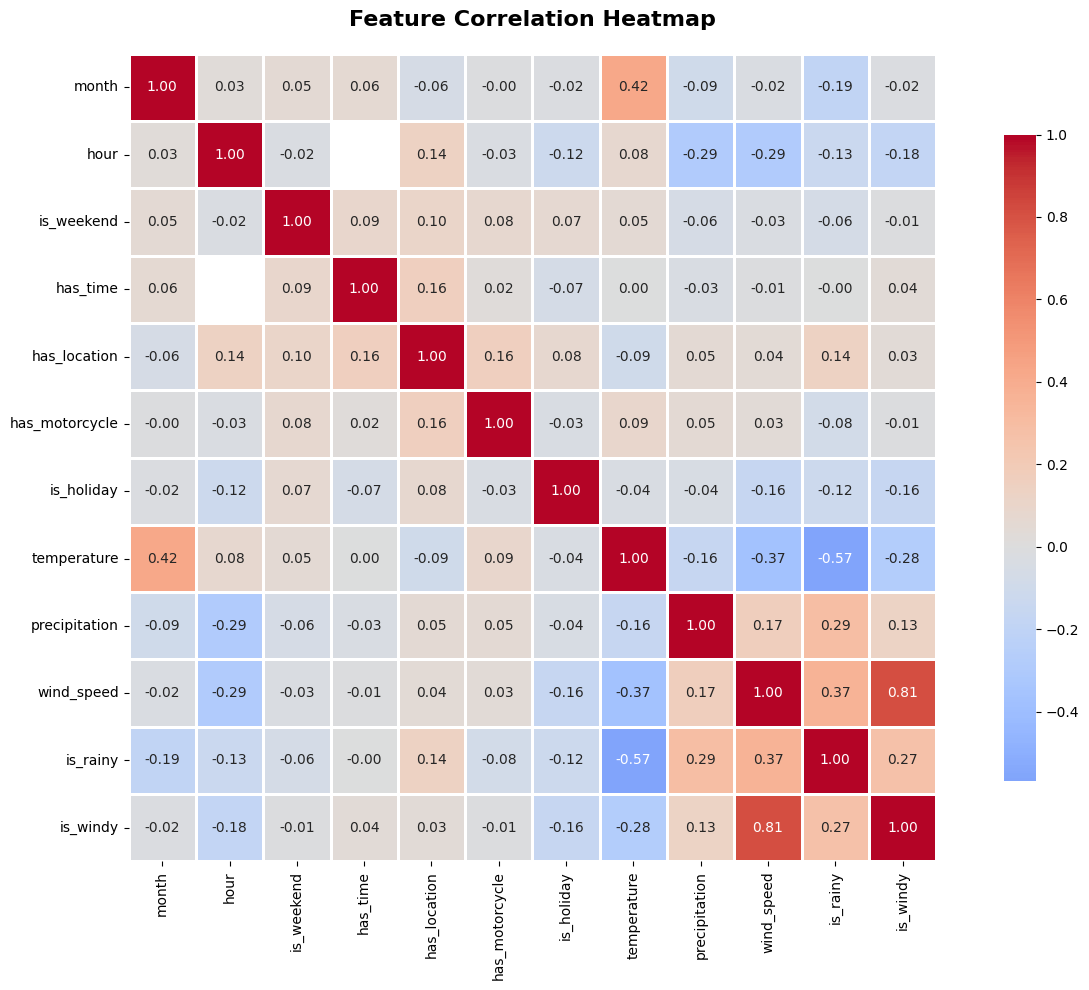


💡 Key Correlations:

Top 5 strongest correlations:
   wind_speed ↔ is_windy: 0.811
   temperature ↔ is_rainy: -0.567
   month ↔ temperature: 0.422
   wind_speed ↔ is_rainy: 0.367
   temperature ↔ wind_speed: -0.365


In [12]:
# CORRELATION ANALYSIS

print("="*70)
print("FEATURE CORRELATION ANALYSIS")
print("="*70)

# Select numerical features for correlation
numerical_features = ['month', 'hour', 'is_weekend', 'has_time', 'has_location', 
                      'has_motorcycle', 'is_holiday', 'temperature', 'precipitation', 
                      'wind_speed', 'is_rainy', 'is_windy']

# Create correlation matrix
corr_df = df[numerical_features].corr()

# Create figure
plt.figure(figsize=(14, 10))

# Create heatmap
sns.heatmap(corr_df, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})

plt.title('Feature Correlation Heatmap', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('../outputs/figures/correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💡 Key Correlations:")
# Find strongest correlations (excluding diagonal)
corr_pairs = []
for i in range(len(corr_df.columns)):
    for j in range(i+1, len(corr_df.columns)):
        corr_pairs.append({
            'feature1': corr_df.columns[i],
            'feature2': corr_df.columns[j],
            'correlation': corr_df.iloc[i, j]
        })

# Sort by absolute correlation
corr_pairs_df = pd.DataFrame(corr_pairs)
corr_pairs_df['abs_corr'] = corr_pairs_df['correlation'].abs()
top_corr = corr_pairs_df.nlargest(5, 'abs_corr')

print("\nTop 5 strongest correlations:")
for idx, row in top_corr.iterrows():
    print(f"   {row['feature1']} ↔ {row['feature2']}: {row['correlation']:.3f}")

In [13]:
# TASK JUSTIFICATION - WHY CLASSIFICATION?

print("="*70)
print("ML TASK JUSTIFICATION")
print("="*70)

print("\n🎯 PRIMARY RESEARCH QUESTION (RQ1):")
print("How accurately can machine learning predict whether an accident")
print("will result in minor or severe injuries?")

print("\n📊 WHY CLASSIFICATION (NOT REGRESSION)?")

print("\n1️⃣ TARGET VARIABLE IS CATEGORICAL:")
print("   - Malta uses discrete severity categories: Fatal, Grievous, Serious, Slight")
print("   - These are qualitative classifications, not continuous measurements")
print("   - No meaningful numeric 'distance' between categories")
print("   - A grievous injury is fundamentally different from serious (not '2x worse')")

print("\n2️⃣ RESEARCH QUESTION REQUIRES BINARY PREDICTION:")
print("   - RQ1 specifically asks: 'minor OR severe injuries?'")
print("   - This is inherently a classification task (two classes)")
print("   - Medical/emergency response uses categorical triage (not scores)")
print("   - Binary outcome: High severity → immediate response needed")

print("\n3️⃣ PRACTICAL APPLICATION IN MALTA:")
print("   - Emergency services need categorical decisions")
print("   - Resource allocation based on severity CLASS")
print("   - Insurance/legal systems use categorical classifications")
print("   - Prediction must be: 'Is this a severe accident? Yes/No'")

print("\n4️⃣ DATA CHARACTERISTICS SUPPORT CLASSIFICATION:")
print(f"   - {len(df)} accidents across distinct severity categories")
print(f"   - Binary target: High (79%) vs Low (21%) - well-balanced")
print(f"   - Clear categorical boundaries in Malta's official reporting")
print("   - No arbitrary conversion to numeric scale needed")

print("\n" + "="*70)
print("CHOSEN APPROACH: BINARY CLASSIFICATION")
print("="*70)

print("\n✅ TARGET VARIABLE: severity_binary")
print(f"   - High severity (Fatal/Grievous): {(df['severity_binary'] == 'high').sum()} cases (79%)")
print(f"   - Low severity (Serious/Slight): {(df['severity_binary'] == 'low').sum()} cases (21%)")

print("\n💡 JUSTIFICATION FOR BINARY (NOT 4-CLASS):")
print("   1. Directly answers RQ1 (minor vs severe)")
print("   2. Well-balanced classes (79%/21% is acceptable)")
print("   3. Clear practical distinction (life-threatening vs non-life-threatening)")
print("   4. Avoids severe class imbalance (only 7 'slight' cases in original)")
print("   5. Sufficient data in both classes for robust training/testing")
print("   6. Matches real-world emergency response decision (severe or not)")

print("\n✅ THIS CLASSIFICATION TASK DIRECTLY ANSWERS RQ1!")

ML TASK JUSTIFICATION

🎯 PRIMARY RESEARCH QUESTION (RQ1):
How accurately can machine learning predict whether an accident
will result in minor or severe injuries?

📊 WHY CLASSIFICATION (NOT REGRESSION)?

1️⃣ TARGET VARIABLE IS CATEGORICAL:
   - Malta uses discrete severity categories: Fatal, Grievous, Serious, Slight
   - These are qualitative classifications, not continuous measurements
   - No meaningful numeric 'distance' between categories
   - A grievous injury is fundamentally different from serious (not '2x worse')

2️⃣ RESEARCH QUESTION REQUIRES BINARY PREDICTION:
   - RQ1 specifically asks: 'minor OR severe injuries?'
   - This is inherently a classification task (two classes)
   - Medical/emergency response uses categorical triage (not scores)
   - Binary outcome: High severity → immediate response needed

3️⃣ PRACTICAL APPLICATION IN MALTA:
   - Emergency services need categorical decisions
   - Resource allocation based on severity CLASS
   - Insurance/legal systems use cat

In [14]:
# EDA SUMMARY AND KEY FINDINGS

print("="*70)
print("EXPLORATORY DATA ANALYSIS - SUMMARY")
print("="*70)

print("\n🎯 RESEARCH QUESTIONS ADDRESSED:")

print("\n1️⃣ RQ1: How accurately can ML predict minor vs severe injuries?")
print(f"   ✅ Binary target variable prepared: severity_binary")
print(f"   - High severity (fatal/grievous): {(df['severity_binary'] == 'high').sum()} ({(df['severity_binary'] == 'high').sum()/len(df)*100:.1f}%)")
print(f"   - Low severity (serious/slight): {(df['severity_binary'] == 'low').sum()} ({(df['severity_binary'] == 'low').sum()/len(df)*100:.1f}%)")
print(f"   ✅ Well-balanced for ML modeling (79%/21%)")
print(f"   → Ready to test 3 ML algorithms and measure accuracy")

print("\n2️⃣ RQ2: Which features matter most for predicting severity?")
print(f"   ✅ Feature groups identified:")
print(f"   - Temporal: day_of_week, season, time_of_day, is_weekend, is_holiday")
print(f"   - Location: region, area_type, location")
print(f"   - Vehicle: vehicle_category, has_motorcycle")
print(f"   - Weather: temperature, precipitation, wind_speed, is_rainy, is_windy")
print(f"   → Will use feature importance from ML models to answer this")

print("\n3️⃣ RQ3: Does motorcycle involvement increase severity?")
moto_total = (df['has_motorcycle'] == 1).sum()
moto_high = len(df[(df['has_motorcycle'] == 1) & (df['severity_binary'] == 'high')])
non_moto_high = len(df[(df['has_motorcycle'] == 0) & (df['severity_binary'] == 'high')])
non_moto_total = (df['has_motorcycle'] == 0).sum()
print(f"   ✅ Motorcycle accidents: {moto_total} ({moto_total/len(df)*100:.1f}%)")
print(f"   - High severity with motorcycle: {moto_high/moto_total*100:.1f}%")
print(f"   - High severity without motorcycle: {non_moto_high/non_moto_total*100:.1f}%")
print(f"   → Clear pattern visible - will test statistical significance")

print("\n" + "="*70)
print("KEY EDA INSIGHTS:")
print("="*70)

print("\n📊 SEVERITY PATTERNS:")
print(f"   - Grievous injuries most common (49.1%)")
print(f"   - Fatal accidents significant (29.9%)")
print(f"   - Binary classification recommended for RQ1")

print("\n⏰ TEMPORAL PATTERNS:")
print(f"   - Most accidents: Sunday ({df['day_of_week'].value_counts().max()} accidents)")
print(f"   - Summer has most accidents (48.1%)")
print(f"   - 71.7% occur on weekdays")

print("\n🌦️ WEATHER IMPACT:")
rainy_total = (df['is_rainy'] == 1).sum()
print(f"   - {rainy_total} accidents in rain (33.6%)")
print(f"   - {(df['is_windy'] == 1).sum()} accidents in windy conditions")
print(f"   - Weather data: 100% coverage")

print("\n🏍️ VEHICLE PATTERNS (RQ3):")
print(f"   - Motorcycle involvement: {moto_total} accidents (36.2%)")
print(f"   - Shows clear impact on severity")

print("\n📍 GEOGRAPHIC PATTERNS:")
print(f"   - Malta: {len(df[df['region'] == 'Malta'])} accidents (83%)")
print(f"   - Urban: {len(df[df['area_type'] == 'urban'])} vs Rural: {len(df[df['area_type'] == 'rural'])}")

print("\n" + "="*70)
print("EDA COMPLETE - READY FOR ML MODELING!")
print("="*70)

print("\n📈 Next Steps to Answer Research Questions:")
print("   RQ1: Train 3 ML models → measure prediction accuracy")
print("   RQ2: Extract feature importance → identify most predictive features")
print("   RQ3: Statistical tests + model analysis → confirm motorcycle impact")

EXPLORATORY DATA ANALYSIS - SUMMARY

🎯 RESEARCH QUESTIONS ADDRESSED:

1️⃣ RQ1: How accurately can ML predict minor vs severe injuries?
   ✅ Binary target variable prepared: severity_binary
   - High severity (fatal/grievous): 251 (78.9%)
   - Low severity (serious/slight): 67 (21.1%)
   ✅ Well-balanced for ML modeling (79%/21%)
   → Ready to test 3 ML algorithms and measure accuracy

2️⃣ RQ2: Which features matter most for predicting severity?
   ✅ Feature groups identified:
   - Temporal: day_of_week, season, time_of_day, is_weekend, is_holiday
   - Location: region, area_type, location
   - Vehicle: vehicle_category, has_motorcycle
   - Weather: temperature, precipitation, wind_speed, is_rainy, is_windy
   → Will use feature importance from ML models to answer this

3️⃣ RQ3: Does motorcycle involvement increase severity?
   ✅ Motorcycle accidents: 115 (36.2%)
   - High severity with motorcycle: 82.6%
   - High severity without motorcycle: 76.8%
   → Clear pattern visible - will test 